In [1]:
from transformers import AutoTokenizer, AutoModel
import torch
import pickle
import matplotlib.pyplot as plt
import numpy as np
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA, FastICA
import os
from sklearn.metrics.pairwise import cosine_similarity

In [2]:
cache_dir = '/scratch/project_2000539/maryam/embed/.cache'

# Disable tokenizers parallelism to avoid the warning
os.environ["TOKENIZERS_PARALLELISM"] = "false"

# Load the tokenizer and model from Hugging Face
model_name = "Salesforce/SFR-Embedding-Mistral"
tokenizer = AutoTokenizer.from_pretrained(model_name, cache_dir=cache_dir)
model = AutoModel.from_pretrained(model_name, cache_dir=cache_dir, torch_dtype=torch.float16)

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

In [8]:
def pad_embeddings(embedding_list):
    max_length = max(embedding.shape[0] for embedding in embedding_list)
    padded_embeddings = []
    
    for embedding in embedding_list:
        if embedding.shape[0] < max_length:
            # Pad the embedding with zeros
            padded_embedding = np.pad(embedding, (0, max_length - embedding.shape[0]), 'constant')
        else:
            # If embedding is longer, truncate it (just in case)
            padded_embedding = embedding[:max_length]
        
        padded_embeddings.append(padded_embedding)
    
    return np.array(padded_embeddings)

def visualize_embedding_clusters(embeddings, method='tsne', n_clusters=5, ax=None):
    """
    Visualize clusters in the embeddings by splitting each into 32 heads and using t-SNE, PCA, or ICA.

    :param embeddings: Embedding array to cluster and visualize.
    :param method: The method to use for dimensionality reduction ('tsne', 'pca', or 'ica').
    :param n_clusters: Number of clusters to visualize using KMeans.
    :param ax: The axis to plot on (optional).
    """    
    embeddings_array = np.array(embeddings)
    n_samples = embeddings_array.shape[0]

    # Step 1: Split each embedding into 32 parts (heads)
    num_heads = 32
    head_size = embeddings_array.shape[1] // num_heads
    split_embeddings = embeddings_array.reshape(n_samples, num_heads, head_size)
    flat_embeddings = split_embeddings.reshape(n_samples * num_heads, head_size)


# Step 2: Apply dimensionality reduction
    if method == 'tsne':
        if n_samples < 2:
            raise ValueError("Number of samples is too small for t-SNE")
        
        perplexity = min(30, n_samples - 1)
        reducer = TSNE(n_components=2, perplexity=perplexity, random_state=42)
    elif method == 'pca':
        reducer = PCA(n_components=2)
    elif method == 'ica':
        reducer = FastICA(n_components=2, random_state=42)
    else:
        raise ValueError("Method must be 'tsne', 'pca', or 'ica'")

    reduced_embeddings = reducer.fit_transform(flat_embeddings)

    # Step 3: Apply KMeans clustering
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_labels = kme3ans.fit_predict(reduced_embeddings)

    # Step 4: Plot with consistent colors for each head
    if ax is None:
        ax = plt.gca()

    colors = plt.cm.get_cmap('tab20', num_heads).colors
    for head_idx in range(num_heads):
        indices = np.arange(head_idx, n_samples * num_heads, num_heads)
        ax.scatter(reduced_embeddings[indices, 0], reduced_embeddings[indices, 1], 
                   color=colors[head_idx], label=f'Head {head_idx+1}', s=50, alpha=0.7)

    ax.set_title(f'Embedding Clusters by Head ({method.upper()})')
    ax.set_xlabel('Component 1')
    ax.set_ylabel('Component 2')
    ax.legend(title="Heads", loc='center left', bbox_to_anchor=(1, 0.5), fontsize='small', ncol=2)

    plt.show()

In [13]:
def plot(embeddings,n_clusters):
    # Create a figure with 1 row and 3 columns of subplots
    fig, axs = plt.subplots(1, 2, figsize=(18, 6))  # 18x6 gives enough width for three plots
    
    # Call each visualization method and pass the specific axis to plot in
    visualize_embedding_clusters(embeddings, method='tsne', n_clusters=n_clusters, ax=axs[0])  # t-SNE on the first plot
    axs[0].set_title("t-SNE")  # Set a title for the first plot
    
    visualize_embedding_clusters(embeddings, method='pca', n_clusters=n_clusters, ax=axs[0])  # PCA on the second plot
    axs[0].set_title("PCA")  # Set a title for the second plot
    
    visualize_embedding_clusters(embeddings, method='ica', n_clusters=n_clusters, ax=axs[1])  # ICA on the third plot
    axs[1].set_title("ICA")  # Set a title for the third plot
    
    # Adjust layout to prevent overlapping elements
    plt.tight_layout()
    
    # Show the combined plot
    plt.show()

In [37]:
news_path = "/scratch/project_2000539/maryam/rag_data/"
news_files = ["volkswagen_articles.txt"] #, "microsoft_articles.txt", "small_data.txt", "boeing_articles.txt"
news_txt = ""

for file in news_files:
    file_path = news_path + file
    f = open(file_path, "r")
    file_text = f.read()
    news_txt += file_text

news_doc_list = news_txt.split("\n@@")

In [6]:
# Define a batch size and max length for each input batch
batch_size = 64
max_length = 128

# Function to batch data
def batchify_data(data, batch_size):
    for i in range(0, len(data), batch_size):
        yield data[i:i + batch_size]
        

In [7]:
# Function to perform mean pooling of embeddings (over the sequence length dimension)
def mean_pooling(embeddings, mask):
    token_embeddings = embeddings  # (batch_size, seq_length, hidden_size)
    input_mask_expanded = mask.unsqueeze(-1).expand(token_embeddings.size()).float()
    sum_embeddings = torch.sum(token_embeddings * input_mask_expanded, 1)
    sum_mask = input_mask_expanded.sum(1)
    return sum_embeddings / sum_mask

In [ ]:
from tqdm import tqdm
total_docs = len(news_doc_list)

with open("/scratch/project_2000539/maryam/volkswagen_file_embeddings.pkl", "wb") as f:

    for doc in tqdm(news_doc_list, desc="Processing documents", total=total_docs):

        # List to collect embeddings
        all_doc_embeddings = []
        # Process the document in batches of sentences or chunks
        for batch in batchify_data(doc, batch_size):
            # Tokenize the batch
            inputs = tokenizer(batch, return_tensors="pt", padding=True, truncation=True, max_length=max_length)

            # Move inputs and model to GPU (if available)
            device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
            inputs = {key: value.to(device) for key, value in inputs.items()}
            model = model.to(device)

            # Get embeddings for the batch
            with torch.no_grad():
                outputs = model(**inputs, output_attentions=True)
                batch_embeddings = outputs.last_hidden_state  # (batch_size, seq_length, hidden_size)
            
            # Get the attention mask (to ignore padding tokens)
            attention_mask = inputs['attention_mask']  # Shape: (batch_size, seq_length)

            # Only keep non-padded tokens
            for i in range(batch_embeddings.size(0)):  # Iterate over the batch
                non_padded_indices = attention_mask[i].nonzero().squeeze(-1)  # Indices of non-padded tokens
                non_padded_embeddings = batch_embeddings[i, non_padded_indices, :]  # Select only non-padded embeddings
                all_doc_embeddings.append(non_padded_embeddings.cpu())
            
        # Concatenate all the non-padded tokens for the document
        all_doc_embeddings = torch.cat(all_doc_embeddings, dim=0)  # (total_seq_length, hidden_size)

        # Perform mean pooling over the entire document (averaging over all tokens)
        doc_attention_mask = torch.ones(all_doc_embeddings.shape[0], dtype=torch.int)  # Full attention for all tokens
        doc_embedding = mean_pooling(all_doc_embeddings.unsqueeze(0), doc_attention_mask.unsqueeze(0))  # (1, hidden_size)

        # Convert the final document embedding to numpy
        doc_embedding = doc_embedding.cpu().numpy()
        
        # Save the document embedding to the pickle file
        pickle.dump(doc_embedding, f)

Processing documents:  67%|██████▋   | 5396/8016 [5:54:42<58:37,  1.34s/it]   

In [2]:
all_embd = []
with open("/scratch/project_2000539/maryam/volkswagen_file_embeddings.pkl", "rb") as f:
    while True:
        try:
            # Load one batch at a time
            padded_embeddings = pickle.load(f)
            
            # Apply mean pooling to the batch
            #pooled_embeddings = mean_pooling(padded_embeddings)
            all_embd.append(padded_embeddings)
        
        except EOFError:
            # End of file reached
            break

all_embd = np.concatenate(all_embd, axis=0)


In [3]:
all_embd.shape

(5313, 4096)

/run/nvme/job_23970450/tmp/ipykernel_3732711/3133905904.py:60: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab20', num_heads).colors


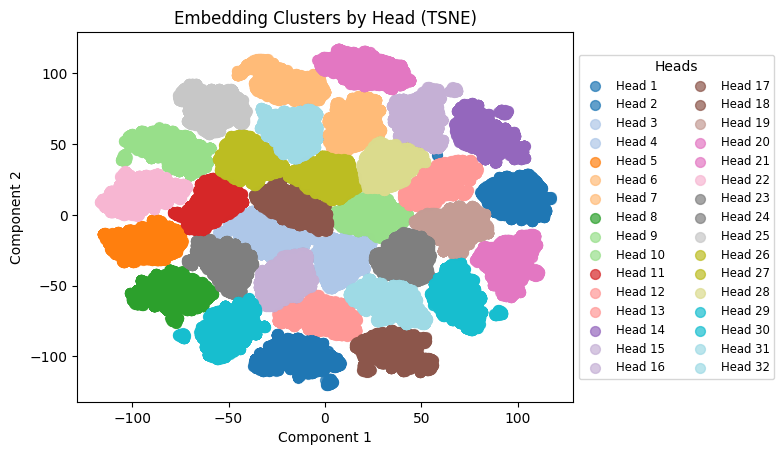

In [15]:
visualize_embedding_clusters(all_embd, method='tsne', n_clusters=5,ax=None)

In [4]:
def visualize_embedding_heads(embeddings, method='tsne', ax=None):
    """
    Visualize clusters in the embeddings by splitting each into 32 heads and using t-SNE, PCA, or ICA.

    :param embeddings: Embedding array to cluster and visualize.
    :param method: The method to use for dimensionality reduction ('tsne', 'pca', or 'ica').
    :param ax: The axis to plot on (optional).
    """    
    embeddings_array = np.array(embeddings)
    n_samples = embeddings_array.shape[0]

    # Step 1: Split each embedding into 32 parts (heads)
    num_heads = 32
    head_size = embeddings_array.shape[1] // num_heads
    split_embeddings = embeddings_array.reshape(n_samples, num_heads, head_size)
    flat_embeddings = split_embeddings.reshape(n_samples * num_heads, head_size)

    # Step 2: Apply dimensionality reduction
    if method == 'tsne':
        if n_samples < 2:
            raise ValueError("Number of samples is too small for t-SNE")
        
        perplexity = min(30, n_samples - 1)
        reducer = TSNE(n_components=2, perplexity=perplexity, random_state=42)
    elif method == 'pca':
        reducer = PCA(n_components=2)
    elif method == 'ica':
        reducer = FastICA(n_components=2, random_state=42)
    else:
        raise ValueError("Method must be 'tsne', 'pca', or 'ica'")

    reduced_embeddings = reducer.fit_transform(flat_embeddings)

    # Step 3: Plot with consistent colors for each head
    if ax is None:
        ax = plt.gca()

    # Assign 32 unique colors, one for each head
    colors = plt.cm.get_cmap('tab20b', num_heads).colors  # Alternative colormap with 32 options

    for head_idx in range(num_heads):
        indices = np.arange(head_idx, n_samples * num_heads, num_heads)
        ax.scatter(reduced_embeddings[indices, 0], reduced_embeddings[indices, 1], 
                   color=colors[head_idx], label=f'Head {head_idx+1}', s=1, alpha=0.7)

    ax.set_title(f'Embedding Visualization by Head ({method.upper()})')
    ax.set_xlabel('Component 1')
    ax.set_ylabel('Component 2')
    #ax.legend(title="Heads", loc='best', fontsize='small', ncol=2)
    ax.legend(title="Heads", loc='center left', bbox_to_anchor=(1, 0.5), fontsize='small', ncol=2)
    plt.show()


/run/nvme/job_24019582/tmp/ipykernel_3086565/3559075565.py:39: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab20b', num_heads).colors  # Alternative colormap with 32 options


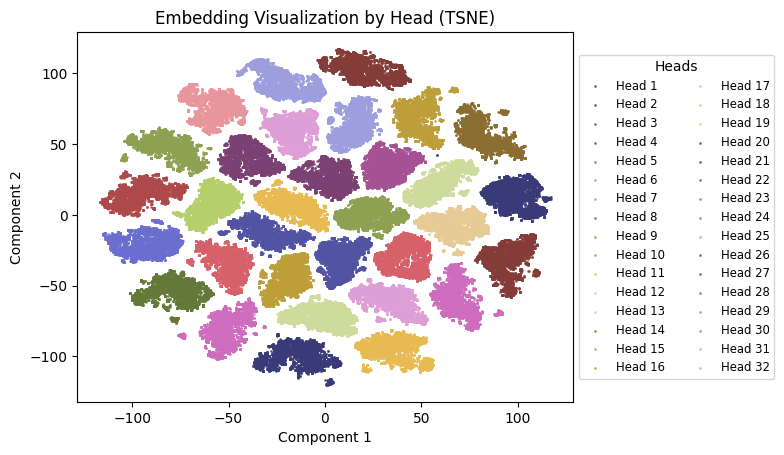

In [5]:
visualize_embedding_heads(all_embd, method='tsne', ax=None)

In [4]:
def visualize_single_head_with_shading(embeddings, method='tsne', head_idx=0, concept_vector=None, ax=None):
    """
    Visualize a single head in the embeddings with color intensity representing similarity to a concept
    or the mean embedding if no concept is provided.

    :param embeddings: Embedding array to visualize.
    :param method: The method to use for dimensionality reduction ('tsne', 'pca', or 'ica').
    :param head_idx: The index of the head to visualize (0 to 31).
    :param concept_vector: A vector representing the retrieved concept to compute similarity (optional).
                           If None, similarity to the mean embedding will be used.
    :param ax: The axis to plot on (optional).
    """    
    embeddings_array = np.array(embeddings)
    n_samples = embeddings_array.shape[0]

    # Step 1: Split each embedding into 32 parts (heads)
    num_heads = 32
    head_size = embeddings_array.shape[1] // num_heads
    split_embeddings = embeddings_array.reshape(n_samples, num_heads, head_size)
    flat_embeddings = split_embeddings.reshape(n_samples * num_heads, head_size)

    # Step 2: Apply dimensionality reduction
    if method == 'tsne':
        if n_samples < 2:
            raise ValueError("Number of samples is too small for t-SNE")
        
        perplexity = min(30, n_samples - 1)
        reducer = TSNE(n_components=2, perplexity=perplexity, random_state=42)
    elif method == 'pca':
        reducer = PCA(n_components=2)
    elif method == 'ica':
        reducer = FastICA(n_components=2, random_state=42)
    else:
        raise ValueError("Method must be 'tsne', 'pca', or 'ica'")

    reduced_embeddings = reducer.fit_transform(flat_embeddings)

    # Step 3: Compute similarity scores using either the concept vector or the mean embedding
    selected_head_embeddings = split_embeddings[:, head_idx, :]
    
    if concept_vector is not None:
        # Use the provided concept vector for similarity
        similarity_scores = cosine_similarity(selected_head_embeddings, concept_vector.reshape(1, -1)).flatten()
    else:
        # If no concept vector, use the mean embedding for the selected head
        mean_embedding = np.mean(selected_head_embeddings, axis=0)
        similarity_scores = cosine_similarity(selected_head_embeddings, mean_embedding.reshape(1, -1)).flatten()

    # Normalize the similarity scores to [0, 1] range for color intensity
    norm_similarity_scores = (similarity_scores - similarity_scores.min()) / (similarity_scores.max() - similarity_scores.min() + 1e-9)

    # Step 4: Plot only the specified head with color intensity based on similarity
    if ax is None:
        ax = plt.gca()

    indices = np.arange(head_idx, n_samples * num_heads, num_heads)  # Only the selected head
    cmap = plt.cm.viridis  # Colormap for gradient
    colors = cmap(norm_similarity_scores)  # Map similarity scores to color shades

    scatter = ax.scatter(reduced_embeddings[indices, 0], reduced_embeddings[indices, 1], 
                         color=colors, s=20, alpha=0.7)  # 's' controls size of dots

    ax.set_title(f'Single Head ({method.upper()}) - Head {head_idx + 1}')
    ax.set_xlabel('Component 1')
    ax.set_ylabel('Component 2')

    # Add a colorbar to indicate the meaning of color intensity
    cbar = plt.colorbar(scatter, ax=ax)
    cbar.set_label('Similarity')

    plt.show()


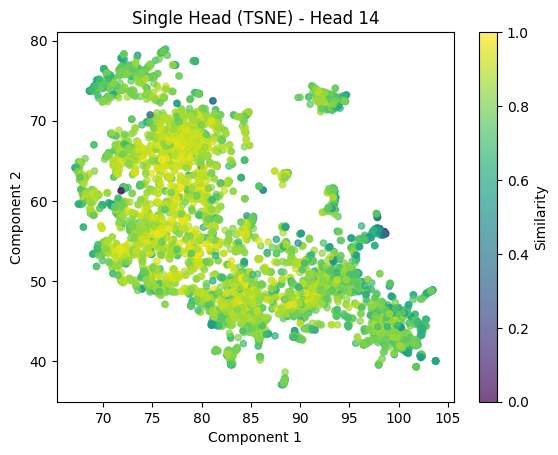

In [5]:
visualize_single_head_with_shading(all_embd, method='tsne', head_idx=13, concept_vector=None, ax=None)

In [3]:
def visualize_single_head_with_magnitude_shading(embeddings, method='tsne', head_idx=0, ax=None):
    """
    Visualize a single head in the embeddings with color intensity representing vector magnitude.

    :param embeddings: Embedding array to visualize.
    :param method: The method to use for dimensionality reduction ('tsne', 'pca', or 'ica').
    :param head_idx: The index of the head to visualize (0 to 31).
    :param ax: The axis to plot on (optional).
    """    
    embeddings_array = np.array(embeddings)
    n_samples = embeddings_array.shape[0]

    # Step 1: Split each embedding into 32 parts (heads)
    num_heads = 32
    head_size = embeddings_array.shape[1] // num_heads
    split_embeddings = embeddings_array.reshape(n_samples, num_heads, head_size)
    flat_embeddings = split_embeddings.reshape(n_samples * num_heads, head_size)

    # Step 2: Apply dimensionality reduction
    if method == 'tsne':
        if n_samples < 2:
            raise ValueError("Number of samples is too small for t-SNE")
        
        perplexity = min(30, n_samples - 1)
        reducer = TSNE(n_components=2, perplexity=perplexity, random_state=42)
    elif method == 'pca':
        reducer = PCA(n_components=2)
    elif method == 'ica':
        reducer = FastICA(n_components=2, random_state=42)
    else:
        raise ValueError("Method must be 'tsne', 'pca', or 'ica'")

    reduced_embeddings = reducer.fit_transform(flat_embeddings)

    # Step 3: Compute magnitudes for each embedding in the selected head
    selected_head_embeddings = split_embeddings[:, head_idx, :]
    magnitudes = np.linalg.norm(selected_head_embeddings, axis=1)

    # Normalize the magnitudes to [0, 1] range for color intensity
    norm_magnitudes = (magnitudes - magnitudes.min()) / (magnitudes.max() - magnitudes.min() + 1e-9)

    # Step 4: Plot only the specified head with color intensity based on magnitude
    if ax is None:
        ax = plt.gca()

    indices = np.arange(head_idx, n_samples * num_heads, num_heads)  # Only the selected head
    cmap = plt.cm.viridis  # Colormap for gradient
    colors = cmap(norm_magnitudes)  # Map magnitudes to color shades

    scatter = ax.scatter(reduced_embeddings[indices, 0], reduced_embeddings[indices, 1], 
                         color=colors, s=20, alpha=0.7)  # 's' controls size of dots

    ax.set_title(f'Single Head ({method.upper()}) - Head {head_idx + 1}')
    ax.set_xlabel('Component 1')
    ax.set_ylabel('Component 2')

    # Add a colorbar to indicate the meaning of color intensity
    cbar = plt.colorbar(scatter, ax=ax)
    cbar.set_label('Magnitude')

    plt.show()


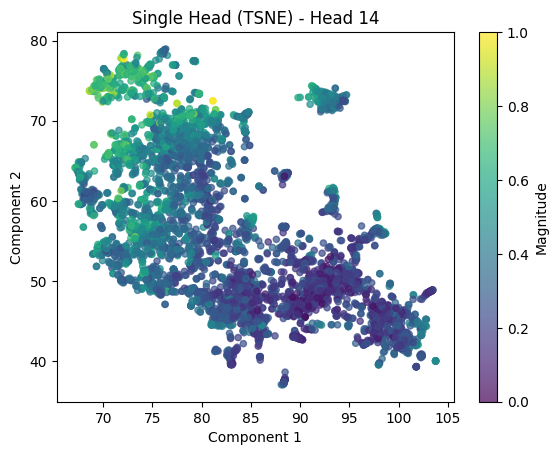

In [4]:
visualize_single_head_with_magnitude_shading(all_embd, method='tsne', head_idx=13, ax=None)

In [7]:
def visualize_embedding_heads_with_magnitude_shading(embeddings, method='tsne', ax=None):
    """
    Visualize clusters in the embeddings by splitting each into 32 heads with color intensity representing magnitude.
    
    :param embeddings: Embedding array to cluster and visualize.
    :param method: The method to use for dimensionality reduction ('tsne', 'pca', or 'ica').
    :param ax: The axis to plot on (optional).
    """    
    embeddings_array = np.array(embeddings)
    n_samples = embeddings_array.shape[0]

    # Step 1: Split each embedding into 32 parts (heads)
    num_heads = 32
    head_size = embeddings_array.shape[1] // num_heads
    split_embeddings = embeddings_array.reshape(n_samples, num_heads, head_size)
    flat_embeddings = split_embeddings.reshape(n_samples * num_heads, head_size)

    # Step 2: Apply dimensionality reduction
    if method == 'tsne':
        if n_samples < 2:
            raise ValueError("Number of samples is too small for t-SNE")
        
        perplexity = min(30, n_samples - 1)
        reducer = TSNE(n_components=2, perplexity=perplexity, random_state=42)
    elif method == 'pca':
        reducer = PCA(n_components=2)
    elif method == 'ica':
        reducer = FastICA(n_components=2, random_state=42)
    else:
        raise ValueError("Method must be 'tsne', 'pca', or 'ica'")

    reduced_embeddings = reducer.fit_transform(flat_embeddings)

    # Step 3: Plot with varying color intensities based on magnitude for each head
    if ax is None:
        ax = plt.gca()

    # Assign 32 base colors, one for each head
    base_colors = plt.cm.get_cmap('tab20b', num_heads).colors  # Colormap with 32 colors

    for head_idx in range(num_heads):
        indices = np.arange(head_idx, n_samples * num_heads, num_heads)

        # Compute magnitudes for the current head's embeddings
        head_embeddings = split_embeddings[:, head_idx, :]
        magnitudes = np.linalg.norm(head_embeddings, axis=1)

        # Normalize magnitudes to [0, 1] for color intensity
        norm_magnitudes = (magnitudes - magnitudes.min()) / (magnitudes.max() - magnitudes.min() + 1e-9)
        
        # Adjust color intensity based on magnitude
        head_colors = [base_colors[head_idx] + (1 - norm) * (1 - np.array(base_colors[head_idx])) for norm in norm_magnitudes]

        ax.scatter(reduced_embeddings[indices, 0], reduced_embeddings[indices, 1], 
                   color=head_colors, label=f'Head {head_idx+1}', s=1, alpha=0.7)

    ax.set_title(f'Embedding Visualization by Head with Magnitude Shading ({method.upper()})')
    ax.set_xlabel('Component 1')
    ax.set_ylabel('Component 2')
    ax.legend(title="Heads", loc='center left', bbox_to_anchor=(1, 0.5), fontsize='small', ncol=2)
    plt.show()


/run/nvme/job_23992182/tmp/ipykernel_817050/2270236338.py:39: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  base_colors = plt.cm.get_cmap('tab20b', num_heads).colors  # Colormap with 32 colors


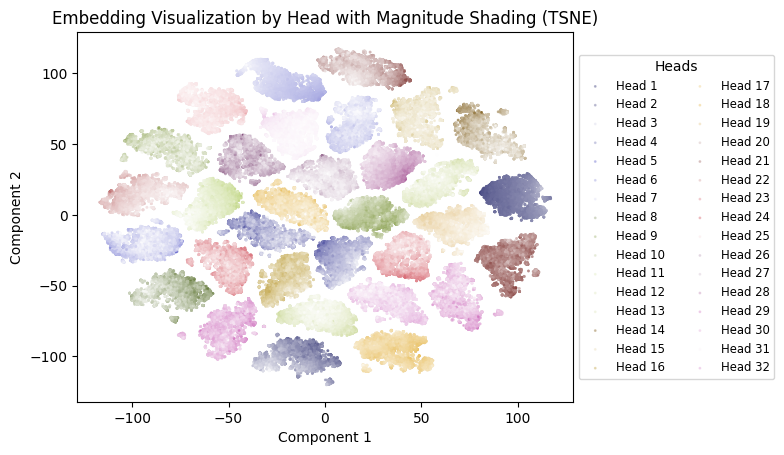

In [8]:
visualize_embedding_heads_with_magnitude_shading(all_embd, method='tsne', ax=None)

In [18]:
def get_top_magnitude_embeddings(embeddings, head_idx=13, top_n=10):
    """
    Get the top N embeddings by magnitude for a specified head and print their associated file names.

    :param embeddings: Array of embeddings.
    :param head_idx: Index of the head to analyze.
    :param top_n: Number of high-magnitude embeddings to retrieve.
    """
    embeddings_array = np.array(embeddings)
    n_samples = embeddings_array.shape[0]

    # Split embeddings into heads and select head 13
    num_heads = 32
    head_size = embeddings_array.shape[1] // num_heads
    split_embeddings = embeddings_array.reshape(n_samples, num_heads, head_size)

    # Calculate magnitudes for embeddings in the specified head
    head_embeddings = split_embeddings[:, head_idx, :]
    magnitudes = np.linalg.norm(head_embeddings, axis=1)

    # Get indices of the top N high-magnitude embeddings
    top_indices = np.argsort(magnitudes)[-top_n:][::-1]  # Sort and get top N indices
    
    return top_indices

In [45]:
ids = get_top_magnitude_embeddings(all_embd, head_idx=0, top_n=25)

In [46]:
top_docs = ""
for idx in ids:
    ##print(news_doc_list[idx])
    #print(f"Preview: {news_doc_list[idx][:250]}")
    top_docs += news_doc_list[idx]
f = open("/scratch/project_2000539/maryam/head0_top25.txt", "w")
f.write(top_docs)
f.close()

In [43]:
def visualize_embedding_specific_heads_with_magnitude_shading(embeddings, specific_heads, method='tsne', ax=None):
    """
    Visualize clusters in the embeddings by splitting each into 32 heads with color intensity representing magnitude.
    
    :param embeddings: Embedding array to cluster and visualize.
    :param method: The method to use for dimensionality reduction ('tsne', 'pca', or 'ica').
    :param ax: The axis to plot on (optional).
    """    
    embeddings_array = np.array(embeddings)
    n_samples = embeddings_array.shape[0]

    # Step 1: Split each embedding into 32 parts (heads)
    num_heads = 32
    head_size = embeddings_array.shape[1] // num_heads
    split_embeddings = embeddings_array.reshape(n_samples, num_heads, head_size)
    flat_embeddings = split_embeddings.reshape(n_samples * num_heads, head_size)

    # Step 2: Apply dimensionality reduction
    if method == 'tsne':
        if n_samples < 2:
            raise ValueError("Number of samples is too small for t-SNE")
        
        perplexity = min(30, n_samples - 1)
        reducer = TSNE(n_components=2, perplexity=perplexity, random_state=42)
    elif method == 'pca':
        reducer = PCA(n_components=2)
    elif method == 'ica':
        reducer = FastICA(n_components=2, random_state=42)
    else:
        raise ValueError("Method must be 'tsne', 'pca', or 'ica'")

    reduced_embeddings = reducer.fit_transform(flat_embeddings)

    # Step 3: Plot with varying color intensities based on magnitude for each head
    if ax is None:
        ax = plt.gca()

    # Assign 32 base colors, one for each head
    base_colors = plt.cm.get_cmap('tab20b', num_heads).colors  # Colormap with 32 colors

    for head_idx in specific_heads:
        indices = np.arange(head_idx, n_samples * num_heads, num_heads)

        # Compute magnitudes for the current head's embeddings
        head_embeddings = split_embeddings[:, head_idx, :]
        magnitudes = np.linalg.norm(head_embeddings, axis=1)

        # Normalize magnitudes to [0, 1] for color intensity
        norm_magnitudes = (magnitudes - magnitudes.min()) / (magnitudes.max() - magnitudes.min() + 1e-9)
        
        # Adjust color intensity based on magnitude
        head_colors = [base_colors[head_idx] + (1 - norm) * (1 - np.array(base_colors[head_idx])) for norm in norm_magnitudes]

        ax.scatter(reduced_embeddings[indices, 0], reduced_embeddings[indices, 1], 
                   color=head_colors, label=f'Head {head_idx+1}', s=1, alpha=0.7)

    ax.set_title(f'Embedding Visualization by Head with Magnitude Shading ({method.upper()})')
    ax.set_xlabel('Component 1')
    ax.set_ylabel('Component 2')
    ax.legend(title="Heads", loc='center left', bbox_to_anchor=(1, 0.5), fontsize='small', ncol=2)
    plt.show()

/run/nvme/job_23992182/tmp/ipykernel_817050/1658955948.py:39: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  base_colors = plt.cm.get_cmap('tab20b', num_heads).colors  # Colormap with 32 colors


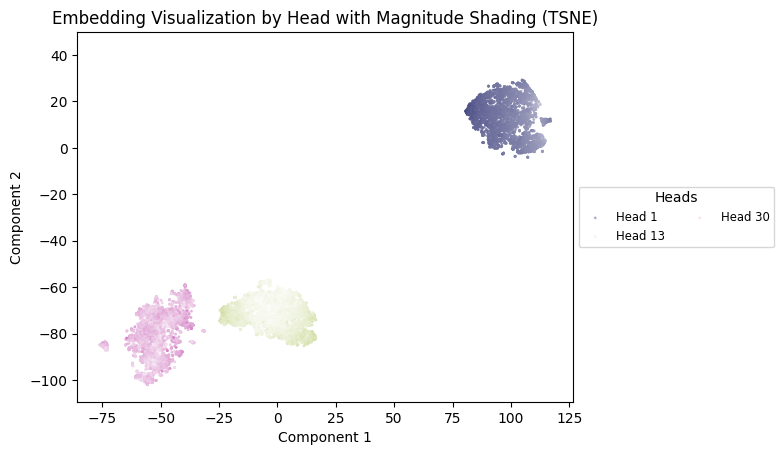

In [44]:
visualize_embedding_specific_heads_with_magnitude_shading(all_embd, [0,12,29], method='tsne', ax=None)